<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/homework/2020-2021/hw1/Tema_1_Skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 1 - A taste for music
## Găsirea genului pentru piese

### Autori: 
* George Muraru
* Alexandru Sorici

## 1. Scopul temei


Tema are ca scop folosirea metodelor de clasificare studiate în cadrul cursului/laboratorului pentru a **determina genul muzical** al unor sample-uri audio dintr-un set de date.

Se dorește înțelegerea procedurii tipice de **prelucrare a unui set de date**, de **explorare a atributelor**, precum și efectuarea unei **analize comparative** a mai multor algoritmi de clasificare, evidențiând diferențele între ei prin metrici precum *acuratețe, precizie, regăsire (eng. recall)*. 

## 2. Set de date

Primul pas în orice problema de data science este încărcarea și "înțelegerea" datelor.

Setul de date utilizat poartă denumirea de Free Music Archive [[1]](#fma). 

Dataset-ul utilizat este "usor" modificat - va conține doar 4 genuri muzicale: *Rock*, *Hip-Hop*, *Folk* și *Electronic*.

Setul de date este deja echilibrat (eng. balanced) -- sunt câte 500 de piese din fiecare gen în setul de train și câte 100 în cel de testare.

Dacă setați parametrul [DOWNLOAD_SAMPLE_DATASET](#scrollTo=te02bqsfMhls) se va descărca și un audio sample pentru fiecare track_id atunci când se rulează celula specifică pentru secțiunea [Descărcare](#scrollTo=RxCYjmzTM82o).

Puteți asculta sample-ul din piesă [aici](#scrollTo=te02bqsfMhls).

Se va folosi drept **clasă** (eticheta care trebuie prezisa) *genul muzical cel mai general* (numele coloanei în engleza este *top_genre*) pentru fiecare piesă.


Setul de date conține pentru fiecare sample mai multe atribute (eng. features), de tip numeric, care pot fi folosite pentru clasificare. Acestea pot fi găsite în fișierele *features.csv* sau *echonest.csv*.


Pentru mai multe informații privind setul de date, se poate consulta [acest repository](https://github.com/mdeff/fma).

Dataset-ul utilizat este o copie ușor modificată a celor [3 dataset-uri](https://github.com/mdeff/fma#Data): *fma_small.zip*, *fma_medium.zip*, *fma_large.zip*.

## 3. Workspace Setup

### Parametrii

In [670]:
# Music samples -- has ~ 2GB
from scipy.stats import reciprocal, uniform
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
DOWNLOAD_SAMPLE_DATASET = True  #@param {type: "boolean"}

### Dependențe

In [671]:
!pip install pandas # needed for loading the dataset
!pip install xgboost

if DOWNLOAD_SAMPLE_DATASET:
    !pip install ffmpeg # Needed by librosa for mp3
    !pip install librosa
    !pip install tqdm # Progress bar for dowloading large file

'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


### Import biblioteci

In [672]:
if DOWNLOAD_SAMPLE_DATASET:
    from tqdm import tqdm
    import librosa

import pandas as pd
from zipfile import ZipFile

import IPython.display as ipd

### Funcții ajutătoare

In [673]:
def _reporthook(t):
    """ ``reporthook`` to use with ``urllib.request`` that prints the process of the download.

    Uses ``tqdm`` for progress bar.

    **Reference:**
    https://github.com/tqdm/tqdm

    Args:
        t (tqdm.tqdm) Progress bar.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        Args:
            b (int, optional): Number of blocks just transferred [default: 1].
            bsize (int, optional): Size of each block (in tqdm units) [default: 1].
            tsize (int, optional): Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

def getHomeworkArchives():
    """ Checks if the homework dataset is present in the local directory, if not,
    downloads it.
    """
    from os import path

    dataset_info = {
        "fma_song_info.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_info.zip",
        "fma_song_samples.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_samples.zip" # Need to upload this
    }

    for dataset_file, dataset_url in dataset_info.items():
        if not path.isfile(dataset_file):
            import urllib
            with tqdm(unit='B', unit_scale=True, miniters=1, desc=dataset_file) as t:
                urllib.request.urlretrieve(dataset_url, filename=dataset_file, reporthook=_reporthook(t))

            assert(path.isfile(dataset_file))

            with ZipFile(dataset_file, 'r') as zip_ref:
                zip_ref.extractall()
        else:
            print(f"{dataset_file} already in the local directory")


# ALL THE FUCTIONS FROM THIS POINT FORWARD ARE NEEDED ONLY IF
# DOWNLOAD_SAMPLE_DATASET IS TRUE
def load_tracks():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/tracks.csv"), index_col=0, header=[0,1])


def load_features():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open('song_info/features.csv'), index_col=0, header=[0,1,2])


def load_echonest():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/echonest.csv"), index_col=0, header=[0,1,2])


def get_song_path(track_id: int):
    ''' Given a track id return the path to the sample

    Args:
        track_id (int): the id for a song found the dataset

    Returns:
        The path to the sample relative to the current directory
    '''

    return f'song_samples/{track_id:06}.mp3'

### Descărcare

In [674]:
getHomeworkArchives()

fma_song_info.zip already in the local directory
fma_song_samples.zip already in the local directory


### Încărcare date

In [675]:
# Load Echonest features for our dataset
echonest = load_echonest()
tracks = load_tracks()
features = load_features()

# True/False masks for selecting training/test
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'].isin(['test', 'validation'])

# Get X and Y
X_train = echonest.loc[train, ('echonest', 'audio_features')]
X_test = echonest.loc[test, ('echonest', 'audio_features')]

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]

## 4. Problemă de rezolvat



Împărțim problema de rezolvat a acestei teme în două subpuncte principale:
  * Implementarea unui clasificator al genului muzical (eng. genre) pentru un anumit sample de piesă prin intermediul a patru algoritmi (KMeans, Decision Trees/Random Forest, XGBoost, SVM, Naive Bayes). Construirea unei variante de baza (eng. baseline) a clasificatorului pentru fiecare algoritm propus.
  * Explorarea metodelor prin care pot fi îmbunătățite rezultatele fiecarui algoritm în parte (e.g. varierea atributelor, prelucrarea suplimentară a atributelor, modificarea hiperparametrilor algoritmului), evaluarea comparativă intra- (i.e. față de baseline pentru același tip de algoritm) și inter-algoritm.

### 4.1. Implementare si rulare clasificatori [6pct]

Pentru acest task se vor rula mai mulți algoritmi pe setul de date și vor fi notate rezultatele obținute.

Veți crea câte un clasificator folosind fiecare din cei patru algoritmi din următoarea listă:
  * KMeans [1 pct]
  * Arbori de decizie, păduri aleatoare [1 pct]
  * XGBoost [1 pct]
  * SVM [1 pct]
  * Naive Bayes [1 pct]

**Observație 1:** Pentru KMeans, fiind **nesupervizat**, vom presupune că *nu* se știe că numărul de clustere este 4.

**Observație 2:** Algoritmii listați **nu** trebuie implementati de mana (nu obligatoriu). Este permisă utilizarea versiunilor din biblioteci cunoscute (a se vedea exemplele sugerate mai jos).


#### **Utilizarea setului de date**
În general, majoritatea seturilor de date sunt împărțite în:
* setul de antrenare (eng. training dataset) - se rulează algoritmul de învățare pe acest set (eng. fit the model)
* setul de validare (eng. validation dataset sau dev set) - se utilizează pentru modificarea hiperparametrilor algoritmului (eng. tunning the hyperparameters)
* setul de testare (eng. testing dataset sau holdout dataset) - se rulează pentru testarea finală a algoritmului.

În scheletul temei, testul de validare și de testare sunt concatenate.

#### **Implementare algoritmi**
Dezvoltați clasificatorii *baseline* pe baza fiecărui algoritm din cei listați mai sus. 
Utilizați implementările default din bibliotecile alese pentru a obține baseline-ul.
Folosiți drept features *audio_features* din tabela de *echonest* (sunt deja selectate în schelet).

Folosiți set-ul *train* pentru antrenare și *test* pentru testare.

#### **Evaluare** [1 pct]
Găsiți [aici](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) o listă cu metrici folosite, in general, pentru evaluarea algoritmilor de machine learning.

Pentru fiecare algoritm în parte, raportați **cel puțin** metricile de *accuracy*, *precision*, *recall*, *f-score* și *matricea de confuzie (eng. confusion matrix)*.

**Observații KMeans**
1. Având în vedere că KMeans nu este un algoritm supervizat, putem să combinăm cele 2 seturi de date (train + testare) pentru a face clusterizarea.
2. Faceți rescale *feature-urilor* astfel încât acestea să fie centrate în 0 cu o deviație standard de 1 - standardizarea datelor (vedeți Referințe).
3. Rulați KMeans pe setul de antrenare utilizând un număr diferit de clustere (eg. 2, 3, 4, 5, 6).
4. Verificați utlizând metoda [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) care este numărul optim de clustere (puteți încerca și cu [elbow](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml) însă va trebui să creșteți lungmea intervalului de clustere).
5. Alegeți numărul optim de clustere și calculați **doar** *randIndex*.
6. [Opțional] Puteți analiza coordonatele centroizilor pentru a observa cum diferă genurile muzicale în funcție de *audio_features*. 
6. [Opțional] Puteți testa să vedeți că piesele din același cluster seamănă utilizând codul de de la finalul notebook-ului.

**Observații DecisionTree/RandomForest**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) din biblioteca scikit-learn. 

**Observații XGBoost**

Implementarea sugerată este cea din biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**Observații SVM**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/svm.html) din biblioteca scikit-learn.

**Observații Naive Bayes**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/naive_bayes.html) din bibilioteca scikit-learn.

#### KMeans

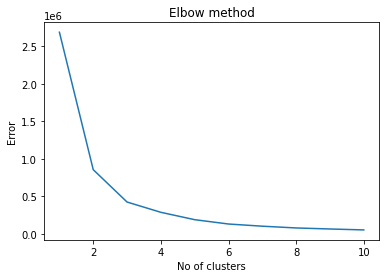

0.6026942355889724
0.7171303258145364


In [676]:
def randIndex(clusters, labels):
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0
    for i in range(Y_test.size):
        for j in range(i + 1, Y_test.size):
            if clusters[i] == clusters[j] and labels[i] == labels[j]:
                true_pos += 1
            if clusters[i] != clusters[j] and labels[i] != labels[j]:
                true_neg += 1
            if clusters[i] == clusters[j] and labels[i] != labels[j]:
                false_pos += 1
            if clusters[i] != clusters[j] and labels[i] == labels[j]:
                false_neg += 1
    return (true_pos+true_neg)/(true_neg+true_pos+false_neg+false_pos)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Error =[]
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(X_train, Y_train)
    Error.append(km.inertia_)

plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

scaler = StandardScaler()
scaled_x = scaler.fit_transform(X_train)
scaled_test = scaler.fit_transform(X_test)



km4 = KMeans(n_clusters=4).fit(X_train, Y_train)
result = km4.predict(X_test)
print(randIndex(result, Y_test.values))

km4 = KMeans(n_clusters=4).fit(scaled_x, Y_train)
result = km4.predict(scaled_test)
print(randIndex(result, Y_test.values))

#### Random Forests

In [677]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

rf_Model = RandomForestClassifier()

rf_Model.fit(X_train, Y_train)
result = rf_Model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, result))
print(confusion_matrix(Y_test, result))
print(classification_report(Y_test, result))


# n_estimators = [500, 800, 1500, 2500, 5000]
# max_features = ['auto', 'sqrt', 'log2']
# max_depth = [10, 20, 30, 40, 50]
# min_samples_split = [2, 5, 10, 15, 20]
# min_samples_leaf = [1, 2, 5, 10, 15]
#
#
# Y_train_maped = Y_train
# Y_test_maped = Y_test
# Y_train_maped[Y_train_maped=='Rock'] = 0
# Y_train_maped[Y_train_maped=='Hip-Hop'] = 1
# Y_train_maped[Y_train_maped=='Electronic'] = 2
# Y_train_maped[Y_train_maped=='Folk'] = 3
#
# Y_test_maped[Y_test_maped=='Rock'] = 0
# Y_test_maped[Y_test_maped=='Hip-Hop'] = 1
# Y_test_maped[Y_test_maped=='Electronic'] = 2
# Y_test_maped[Y_test_maped=='Folk'] = 3
#
# grid_param = {'n_estimators' : n_estimators,
#               'max_features' : max_features,
#               'max_depth' : max_depth,
#               'min_samples_split' : min_samples_split,
#               'min_samples_leaf' : min_samples_leaf}
#
# rfr = RandomForestRegressor(random_state=1)
# rf_Model  = RandomizedSearchCV(estimator=rfr,
#                                param_distributions=grid_param,
#                                n_iter=100,
#                                cv=5,
#                                verbose=2,
#                                random_state=42,
#                                n_jobs=-1)
#
# rf_Model.fit(X_train, Y_train_maped.values)
# print(rf_Model.best_params_)

rf_Model = RandomForestClassifier(n_estimators=800,
                                  min_samples_split=20,
                                  min_samples_leaf=5,
                                  max_features='log2',
                                  max_depth=40)

rf_Model.fit(X_train, Y_train)
result = rf_Model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, result))
print(confusion_matrix(Y_test, result))
print(classification_report(Y_test, result))


Accuracy: 0.7375
[[64 12 16  8]
 [ 1 85  1 13]
 [13  3 81  3]
 [11 16  8 65]]
              precision    recall  f1-score   support

  Electronic       0.72      0.64      0.68       100
        Folk       0.73      0.85      0.79       100
     Hip-Hop       0.76      0.81      0.79       100
        Rock       0.73      0.65      0.69       100

    accuracy                           0.74       400
   macro avg       0.74      0.74      0.73       400
weighted avg       0.74      0.74      0.73       400



#### XGBoost

In [678]:
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
result = xgb.predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, result))
print(confusion_matrix(Y_test, result))
print(classification_report(Y_test, result))

# xgb_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier',XGBClassifier())])
# gbm_param_grid = {
#     'classifier__learning_rate': np.array([0.01,0.001]),
#     'classifier__n_estimators': np.array([100,200,300,400]),
#     'classifier__subsample': np.array([0.7,0.8,0.9]),
#     'classifier__max_depth': np.array([10,11,12,13,14,15,16,17]),
#     'classifier__lambda': np.array([1]),
#     'classifier__gamma': np.array([0])}
# xgb = GridSearchCV(estimator=xgb_pipeline,
#                    param_grid=gbm_param_grid,
#                    n_jobs= -1,
#                    scoring='f1_weighted',
#                    verbose=10)

xgb = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
xgb.fit(X_train, Y_train)
result = xgb.predict(X_test)


print("Accuracy:",metrics.accuracy_score(Y_test, result))
print(confusion_matrix(Y_test, result))
print(classification_report(Y_test, result))

[20:58:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7225
[[64 12 13 11]
 [ 5 80  1 14]
 [13  3 81  3]
 [12 17  7 64]]
              precision    recall  f1-score   support

  Electronic       0.68      0.64      0.66       100
        Folk       0.71      0.80      0.75       100
     Hip-Hop       0.79      0.81      0.80       100
        Rock       0.70      0.64      0.67       100

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400

[20:58:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be acc

c:\users\tdumi\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\tdumi\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#### SVM

In [679]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, Y_train)
result = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, result))
print(confusion_matrix(Y_test, result))
print(classification_report(Y_test, result))


# lin_clf = LinearSVC(random_state=42)
# param_grid = {"gamma": [1,0.1,0.01,0.001,0.0001], "C": [0.1, 1, 10, 100, 1000], "kernel" : ['rbf', 'linear']}
#
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
# grid.fit(X_train, Y_train)
#
# print(grid.best_params_)
# print(grid.best_estimator_)

clf = svm.SVC(kernel='linear', gamma=0.001, C=1000)
clf.fit(X_train, Y_train)
result = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, result))
print(confusion_matrix(Y_test, result))
print(classification_report(Y_test, result))

Accuracy: 0.715
[[67 13 11  9]
 [ 1 86  1 12]
 [18  4 72  6]
 [17 13  9 61]]
              precision    recall  f1-score   support

  Electronic       0.65      0.67      0.66       100
        Folk       0.74      0.86      0.80       100
     Hip-Hop       0.77      0.72      0.75       100
        Rock       0.69      0.61      0.65       100

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400



#### Naive Bayes

In [680]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
result = gnb.fit(X_train, Y_train).predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, result))
print(confusion_matrix(Y_test, result))
print(classification_report(Y_test, result))

# gnb = GaussianNB()
# skf = StratifiedKFold(n_splits=10)
# params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
# gs_NB = GridSearchCV(estimator=gnb,
#                  param_grid=params_NB,
#                  cv=skf,   # use any cross validation technique
#                  verbose=1,
#                  scoring='accuracy')
# gs_NB.fit(X_train, Y_train)
# print(gs_NB.best_params_)

gnb = GaussianNB(var_smoothing=4.328761281083053e-06)
result = gnb.fit(X_train, Y_train).predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_test, result))
print(confusion_matrix(Y_test, result))
print(classification_report(Y_test, result))

Accuracy: 0.7
[[63 13 11 13]
 [ 1 87  1 11]
 [19  3 75  3]
 [16 18 11 55]]
              precision    recall  f1-score   support

  Electronic       0.64      0.63      0.63       100
        Folk       0.72      0.87      0.79       100
     Hip-Hop       0.77      0.75      0.76       100
        Rock       0.67      0.55      0.60       100

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



### 4.2. Metode de îmbunătățire și evaluare comparativă [4pct]

Pentru fiecare algoritm, explorați metode prin care să îmbunătățiți performanțele de la pasul precedent (cel de realizarea a baseline-ului).

**Îmbunătățire algoritmi** [2 pct]

Aveți în vedere următoarea listă de idei (și nu numai):
* adăugarea de mai multe feature-uri (momentan la baseline s-au folosit doar *audio_features*)
* [preprocesarea datelor](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) (eng. data preprocessing)
* [selectarea atributelor](https://scikit-learn.org/stable/modules/feature_selection.html) (eng. feature selection)
* modificarea hiperparametrilor fiecărui algoritm (e.g. tipul de kernel la SVM, coeficienți de regularizare, numărul de arbori în RandomForest, adâncimea arborilor în RandomForest)
    * **Atenție!**, exemplu de **AȘA NU**: rularea cu un număr maxim de 10 iterații la baseline și 100 de iterații la modelul mai bun.

În *fma_song_info.zip* există și un fișier *features.csv* -- detalii despre acesta se găsesc în repository-ul menționat în secțiunea [Set de date](#scrollTo=67UlrcAdqj3N).

**Evaluare îmbunătățiri** [2 pct]

* Evaluați variantele îmbunătățite ale algoritmilor, folosind 5-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). Folosiți aceleași metrici ca în cazul baseline-ului.  **Atenție!** Pentru cross-validation trebuie să vă refaceti împartirea in train/test a setului de date.
* Realizați grafice în care să arătați analiza intra-algoritm a performanței îmbunătățirii (e.g. folosiți un bar chart pentru a compara accuracy-ul variantei baseline a RandomForest cu cea a variantei îmbunătățite).
* Realizați grafice în care să arătați analiza inter-algoritm a performanțelor. Faceți câte un grafic per metrică (e.g. accuracy, precision, recall) în care să încludeți valorile obținute de fiecare algoritm îmbunătățit în parte. 
* Redactați, pe seama graficelor, o analiză a acestora, evidențiind avantajele și dezavantajele fiecărui algoritm implementat.

## 5. Mențiuni

**Pentru rezolvarea task-urilor puteți folosi orice bibliotecă doriți.**

În scheletul temei, datele sunt încărcate folosind biblioteca [pandas](https://pandas.pydata.org/), însă puteți utiliza orice bibliotecă doriți.

**Algoritmii nu trebuie implementați de mână.**

"Rezolvarea" unei probleme de învățare automată se reduce la îmbunătățirea unei metrici.

Un prim pas important este reprezentat de crearea unui *baseline* sau a unei soluții banale, de start (eng. *vanilla solution*) și măsurarea acesteia.

Următorul pas îl reprezintă o serie de modificări aduse feature setului sau algoritmului de învățăre. Aceast pas reprezintă o iterație peste soluția inițială.

Tot procesul constă în aplicarea mai multor *iterații* până se ajunge la o valoare a metricii suficient de bună pentru problema de rezolvat. În cazul nostru, această valoare este reprezentată de ambiția fiecăruia dintre voi :)

**Recomandări**:
* biblioteca [sklearn](https://scikit-learn.org/) - oferă o colecție algoritmi de învățare automată, metrici, metode de selectare de caractaristici, etc.
* pentru XGBoost puteți folosit biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/)

## 6. Sample test
Biblioteca [librosa](https://librosa.github.io/librosa/) permite analizarea și redarea sunetelor.

Se poate folosi pentru a observa dacă anumite melodii găsite într-un anumit gen muzical sunt asemănătoare.

In [681]:
track_test = tracks[test].sample(1)
title = track_test[('track', 'title')].values[0]
genre = track_test[('track', 'genre_top')].values[0]
print(f"Song\n\ttitle: {title}\n\tgenre {genre}")

song_path = get_song_path(track_test.index.values[0])
song, rate = librosa.load(song_path)
ipd.Audio(song, rate=rate)

Song
	title: Complicity
	genre Hip-Hop


c:\users\tdumi\appdata\local\programs\python\python37\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


NoBackendError: 

## 7. Link-uri utile
* [Evaluarea algoritmilor de clusterizare](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)
* [Standardizare vs Normalizare](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)

## Bibliografie
<a name="fma">[1] *Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, FMA: A Dataset For Music Analysis, 18th International Society for Music Information Retrieval Conference, 2017*</a>

